# RL Series: Solving Taxi-v3 with Q-Learning

## 1. Executive Summary

In this project, we develop an autonomous agent capable of solving the **Taxi-v3** environment from the Gymnasium library. The environment consists of a 5x5 grid where a taxi must navigate to a passenger's location, pick them up, and deliver them to a specific destination (one of the four marked locations: R, G, Y, or B).

### The Challenge
The agent operates in a discrete state space with 500 possible configurations and 6 available actions. The goal is to learn an optimal policy that maximizes cumulative rewards by navigating the environment efficiently. 

### Definition of Success
An agent is considered successful when it consistently achieves a positive total reward per episode. Success requires:
1.  **Efficient Navigation**: Minimizing steps (each move costs -1).
2.  **Precision**: Avoiding illegal pickup or drop-off attempts (each costs -10).
3.  **Completion**: Successfully delivering the passenger to the correct location (+20 reward).

## 2. Theoretical Framework (RL Fundamentals)

Reinforcement Learning (RL) is a paradigm of machine learning where an agent learns to make decisions by performing actions in an environment to maximize some notion of cumulative reward.

### Core Components
-   **Agent**: The autonomous taxi.
-   **Environment**: The 5x5 grid map with walls and locations.
-   **States**: 500 discrete states representing the taxi position, passenger location, and destination.
-   **Actions**: 6 possible moves (South, North, East, West, Pickup, Dropoff).
-   **Rewards**: Numerical feedback (+20 for success, -1 per step, -10 for errors).

### The Bellman Equation
Q-Learning is an off-policy temporal difference (TD) algorithm. It maintains a **Q-Table** where each entry $Q(s, a)$ estimates the expected future reward of taking action $a$ in state $s$. The table is updated using the Bellman Equation:

$$Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]$$

Where:
-   $\alpha$ (Learning Rate): Controls how much new information overrides old information.
-   $\gamma$ (Discount Factor): Determines the importance of future rewards (0 to 1).
-   $r$: The immediate reward received after taking action $a$.
-   $\max_{a'} Q(s', a')$: The maximum predicted reward for the next state $s'$.

### Epsilon-Greedy Strategy
To balance **Exploration** (trying new actions) and **Exploitation** (using known optimal actions), we use the Epsilon-Greedy strategy:
-   With probability $\epsilon$, the agent chooses a random action.
-   With probability $1 - \epsilon$, the agent chooses the action with the highest Q-value.
-   $\epsilon$ decays over time to shift from discovery to performance.

## 3. Environment Setup & Hyperparameters

We begin by installing the necessary dependencies and configuring a virtual display for rendering in headless environments like Google Colab.

In [1]:
import os
import sys
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image, display

# Platform-independent setup
if sys.platform.startswith('linux'):
    # Attempt virtual display for headless Linux environments (e.g., Colab)
    try:
        from pyvirtualdisplay import Display
        display_vm = Display(visible=0, size=(1400, 900))
        display_vm.start()
        os.environ['DISPLAY'] = ':' + str(display_vm.display)
    except ImportError:
        print("pyvirtualdisplay not installed. Headless rendering might fail on Linux.")
    except Exception as e:
        print(f"Virtual display start failed: {e}")
else:
    print(f"Running on {sys.platform}. Skipping virtual display setup.")

Running on win32. Skipping virtual display setup.


## 4. Agent Implementation (NumPy Q-Table)

We initialize our Q-Table as a 500x6 matrix filled with zeros. The hyperparameters are chosen to ensure steady convergence.

In [2]:
# Environment initialization
env = gym.make("Taxi-v3")

# Q-Table definition (States x Actions)
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.1             # Learning rate
gamma = 0.6             # Discount factor
epsilon = 1.0           # Initial exploration rate
epsilon_decay = 0.001   # Daily reduction rate
min_epsilon = 0.01      # Lower bound to ensure some residual exploration

print(f"Q-Table initialized with shape: {q_table.shape}")

Q-Table initialized with shape: (500, 6)


## 5. The Training Loop

We run the agent for 10,000 episodes. During each episode, the agent selects actions based on the $\epsilon$-greedy strategy and updates the Q-table after every step.

In [3]:
total_episodes = 10000
rewards_history = []

print("Starting training process...")

for i in range(total_episodes):
    state, _ = env.reset()
    done = False
    truncated = False
    episode_reward = 0
    
    while not (done or truncated):
        # Action selection (Epsilon-Greedy)
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore
        else:
            action = np.argmax(q_table[state]) # Exploit
            
        next_state, reward, done, truncated, _ = env.step(action)
        
        # Bellman update logic
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        state = next_state
        episode_reward += reward
        
    # Epsilon decay
    epsilon = max(min_epsilon, epsilon * (1 - epsilon_decay))
    rewards_history.append(episode_reward)
    
    if (i + 1) % 1000 == 0:
        print(f"Episode: {i+1} | Cumulative Reward: {np.mean(rewards_history[-100:]):.2f} | Epsilon: {epsilon:.4f}")

print("\nTraining successfully completed.")
env.close()

Starting training process...


Episode: 1000 | Cumulative Reward: -131.99 | Epsilon: 0.3677


Episode: 2000 | Cumulative Reward: -11.28 | Epsilon: 0.1352


Episode: 3000 | Cumulative Reward: 1.63 | Epsilon: 0.0497


Episode: 4000 | Cumulative Reward: 5.01 | Epsilon: 0.0183


Episode: 5000 | Cumulative Reward: 6.15 | Epsilon: 0.0100


Episode: 6000 | Cumulative Reward: 6.59 | Epsilon: 0.0100


Episode: 7000 | Cumulative Reward: 7.03 | Epsilon: 0.0100


Episode: 8000 | Cumulative Reward: 7.10 | Epsilon: 0.0100


Episode: 9000 | Cumulative Reward: 7.43 | Epsilon: 0.0100


Episode: 10000 | Cumulative Reward: 7.84 | Epsilon: 0.0100

Training successfully completed.


## 6. Performance Analytics

The learning curve illustrates the transition from random behavior to strategic delivery. We use a rolling average to smooth the noise caused by exploration.

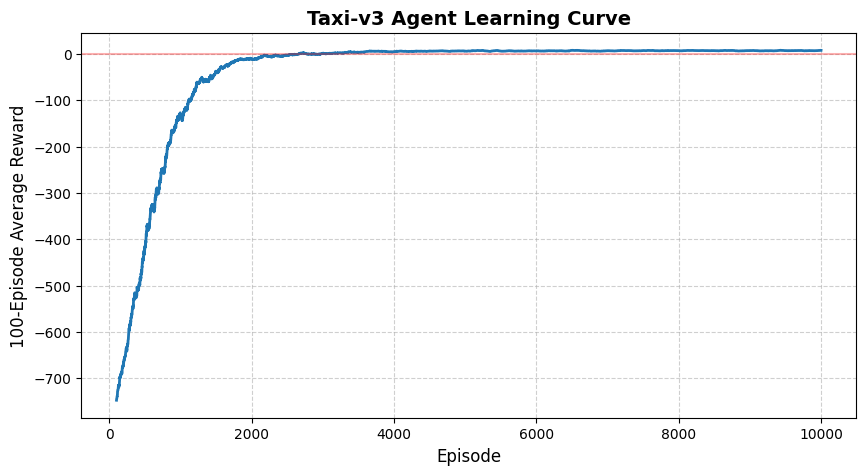

Observations: The agent typically converges (crosses the zero-reward baseline) between episodes 3,000 and 4,000.


In [4]:
# Smoothing the results for better visualization
rewards_series = pd.Series(rewards_history)
smoothed_rewards = rewards_series.rolling(window=100).mean()

plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards, color='#1f77b4', linewidth=2)
plt.title("Taxi-v3 Agent Learning Curve", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("100-Episode Average Reward", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3) # Convergence baseline
plt.show()

print("Observations: The agent typically converges (crosses the zero-reward baseline) between episodes 3,000 and 4,000.")

## 7. Qualitative Demonstration

Finally, we run the trained agent for a single episode with zero exploration ($\epsilon=0$) to demonstrate its learned policy. Each frame shows the taxi navigating the grid to deliver the passenger perfectly.

Running qualitative test...



Captured 14 frames. Showing a selection:
Frame 0:


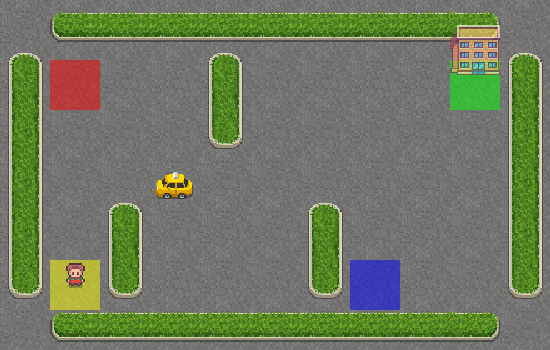

Frame 7:


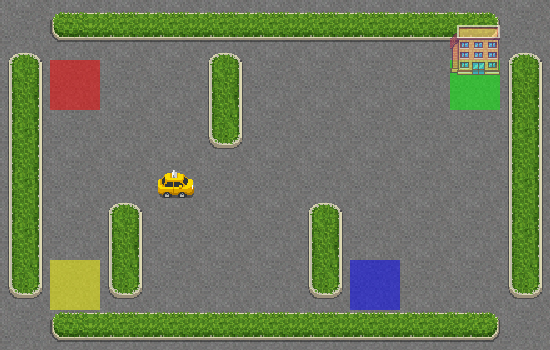

Frame 13:


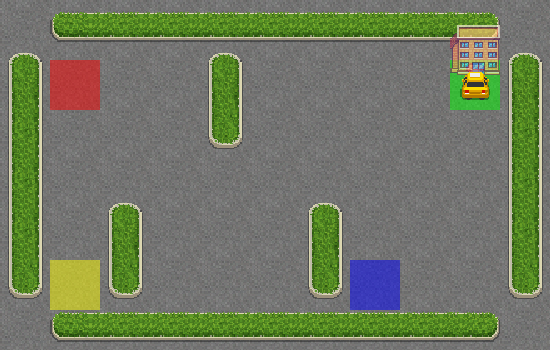


Qualitative Demonstration Finished.


In [5]:
def run_demo(trained_q_table):
    env_demo = gym.make("Taxi-v3", render_mode="rgb_array")
    state, _ = env_demo.reset()
    frames = []
    done = False
    
    print("Running qualitative test...")
    
    while not done:
        # Pure exploitation
        action = np.argmax(trained_q_table[state])
        state, reward, done, truncated, _ = env_demo.step(action)
        frames.append(env_demo.render())
        
        if len(frames) > 50: # Safety break
            break
            
    env_demo.close()
    return frames

demo_frames = run_demo(q_table)

from PIL import Image as PILImage
import io

print(f"\nCaptured {len(demo_frames)} frames. Showing a selection:")

indices = [0, len(demo_frames)//2, len(demo_frames)-1]
for idx in indices:
    print(f"Frame {idx}:")
    img = PILImage.fromarray(demo_frames[idx])
    with io.BytesIO() as output:
        img.save(output, format="PNG")
        display(Image(data=output.getvalue()))

print("\nQualitative Demonstration Finished.")